# Ταξινόμηση ιδιοτήτων-προτάσεων σε συστήματα οργάνων

In [5]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
import string
import spacy
import el_core_news_md
nlp = el_core_news_md.load()
from greek_stemmer import GreekStemmer
stemmer = GreekStemmer()
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

total_stop_words = (nlp.Defaults.stop_words).union(set(stopwords.words('greek')))
total_stop_words = total_stop_words.union({'ή', 'μόνον'})
total_puncts = string.punctuation + '«»–“”\xa0‘•…●\uf0b7◗♥.'
total_stop_words = list(total_stop_words) + list(string.punctuation)
#total_stop_words += [stemming(word) for word in total_stop_words]
stop_words = set(total_stop_words)
tokenized_stop_words = nltk.word_tokenize(' '.join(total_stop_words))

class Tokenizer(object):
    def __init__(self):
        nltk.download('punkt', quiet=True, raise_on_error=True)
        self.stemmer = GreekStemmer()
        
    def _stem(self, token):
        if (token in stop_words):
            return token
        return self.stemmer.stem((removing_accents(token)).upper())
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        tokens = filter_punctuation(list(tokens))
        tokens = group_numbers(tokens)
        tokens = (self._stem(token) for token in tokens)
        return tokens



def data_preparation(data_filename, target, test_size=0.25, stopwords=tokenized_stop_words, max_frequency=0.5, min_frequency=6, 
                     imbalanced=False):
    df_texts = pd.read_csv(data_filename, index_col=None)
    df_texts = df_texts.dropna(axis=0, subset = [target])
    df_texts[target] = df_texts[target].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(df_texts['Sentence'], df_texts[target], test_size=test_size, 
                                                        random_state=10)
    vectorizer = TfidfVectorizer(max_df=max_frequency, min_df=min_frequency, stop_words=stopwords, tokenizer=Tokenizer())
    X_train_tf_idf = vectorizer.fit_transform(X_train)
    dump(vectorizer, 'tf_idf_vectorizer.joblib')
    X_test_tf_idf = vectorizer.transform(X_test)
    if imbalanced:
        ros = RandomOverSampler(random_state=0)
        X_train_tf_idf, y_train = ros.fit_sample(X_train_tf_idf, y_train)
    
    return X_train_tf_idf, X_test_tf_idf, y_train, y_test



def filter_punctuation(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in total_puncts)

        if not all(pun):
            word = word.strip(total_puncts)
            
            if (len(word)>3):
                for punct in total_puncts:
                    word = word.replace(punct, ' ')
            else:
                for punct in total_puncts:
                    word = word.replace(punct, '')
                    
            tokens = nltk.word_tokenize(word)
            
            for token in tokens:
                filtered_words.append(token)
                
    return filtered_words



def group_numbers(words):
    new_words = []
    for word in words:
        if re.fullmatch(r'[0-9]+', word) != None :
            if int(word) >= 1800 and int(word) <= 2020:
                word = '2000'
            else:
                word = '1'
        new_words.append(word)
    return new_words



def removing_accents(word):
    """
    Removes accents from a given word.
    
    Parameters
    ----------
    word : str
        the word from which we want to remove the accents

    Returns
    -------
    str
        the word without accents
    """
    return (word.replace('ά', 'α').replace('έ', 'ε').replace('ή', 'η').replace('ί', 'ι').replace('ό', 'ο').replace('ύ', 'υ')
            .replace('ώ', 'ω').replace('ϊ', 'ι').replace('ϋ', 'υ').replace('ΐ', 'ι').replace('ΰ', 'υ'))



def stemming(word):
    """
    Implements stemming for a given word.
    
    Parameters
    ----------
    word : str
        the word that is about to be stemmed

    Returns
    -------
    str
        the stem of the given word at uppercase letters
    """
    return stemmer.stem((removing_accents(word)).upper())



def classification(dataset_filename, target_column, classifier, target_names, test_size=0.25, stopwords=tokenized_stop_words, 
                   max_frequency=0.5, min_frequency=6, imbalanced=False):    
    
    X_train, X_test, y_train, y_test = data_preparation(dataset_filename, target_column, imbalanced=imbalanced)
    
    switcher = {'dummy': DummyClassifier(), 'svc': SVC(), 'knn': KNeighborsClassifier(), 
                'decision_tree': DecisionTreeClassifier(), 'random_forest': RandomForestClassifier()}
    
    switcher2 = {'dummy': {'estimator__strategy': ['stratified', 'most_frequent', 'prior', 'uniform']}, 
                 'svc': {'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'estimator__C':[0.1, 1, 10], 
                        'estimator__degree': [2,3], 'estimator__coef0': [-1, 0, 1]}, 
                 'knn': {'estimator__n_neighbors': range(10,45,5)}, 
                 'decision_tree': {'estimator__criterion': ['gini', 'entropy'], 'estimator__splitter': ['best', 'random'], 
                                   'estimator__max_depth': [4, 8, 16, 32, 64]}, 
                 'random_forest': {'estimator__n_estimators': range(10, 160, 10), 'estimator__criterion': ['gini', 'entropy'], 
                                   'estimator__max_depth': [4, 8, 16, 32, 64]}}
    
    bin_clf = switcher.get(classifier)
    param_grid = switcher2.get(classifier)
    
    clf = OneVsRestClassifier(bin_clf)
    
    model = GridSearchCV(clf, param_grid, scoring = 'accuracy', cv=5, n_jobs=-1).fit(X_train, y_train)
    dump(model.best_estimator_, (classifier + '.joblib')) 
    
    preds = model.predict(X_test)
    
    results = list(zip(X_test, y_test, preds))
    accuracy = accuracy_score(y_test, preds)
    rep = classification_report(y_test, preds, target_names=target_names)
    return model, results, accuracy, rep

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Πρώτα δοκιμάζουμε σύμφωνα με το απλούτσερο annotation

In [4]:
targets = ['κανένα', 'νευρικό', 'κυκλοφορικό', 'ανοσοποιητικό', 'ουροποιητικό']

In [5]:
model1, res1, accuracy1, report1 = classification('../data/properties.csv', 'Class1', 'svc', targets)

In [11]:
print(report1)

               precision    recall  f1-score   support

       κανένα       1.00      1.00      1.00       157
      νευρικό       1.00      1.00      1.00        81
  κυκλοφορικό       0.99      1.00      0.99        75
ανοσοποιητικό       1.00      0.99      0.99        86
 ουροποιητικό       1.00      1.00      1.00       104

    micro avg       1.00      1.00      1.00       503
    macro avg       1.00      1.00      1.00       503
 weighted avg       1.00      1.00      1.00       503



In [7]:
accuracy1

0.9980119284294234

In [8]:
model1.best_estimator_

OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=-1,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None)

Έπειτα, δοκιμάζουμε το πιο μεγάλο annotated dataset

In [6]:
targets = ['κανένα', 'νευρικό', 'κυκλοφορικό', 'ανοσοποιητικό', 'ουροποιητικό', 'πεπτικό', 'αναπνευστικό', 'ερειστικό', 'μυϊκό',
           'καλυπτήριο', 'αναπαραγωγικό', 'αισθητήριο', 'ενδοκρινών']

In [7]:
model0, res0, accuracy0, report0 = classification('../data/properties.csv', 'Class2', 'dummy', targets)

In [9]:
accuracy0

0.19849319037960012

In [10]:
model0.best_estimator_

OneVsRestClassifier(estimator=DummyClassifier(constant=None, random_state=None, strategy='prior'),
          n_jobs=None)

In [8]:
print(report0)

               precision    recall  f1-score   support

       κανένα       0.00      0.00      0.00       605
      νευρικό       0.00      0.00      0.00       300
  κυκλοφορικό       0.00      0.00      0.00       487
ανοσοποιητικό       0.00      0.00      0.00        85
 ουροποιητικό       0.00      0.00      0.00       173
      πεπτικό       0.20      1.00      0.33       685
 αναπνευστικό       0.00      0.00      0.00       304
    ερειστικό       0.00      0.00      0.00       168
        μυϊκό       0.00      0.00      0.00        67
   καλυπτήριο       0.00      0.00      0.00       259
αναπαραγωγικό       0.00      0.00      0.00       126
   αισθητήριο       0.00      0.00      0.00       126
   ενδοκρινών       0.00      0.00      0.00        66

    micro avg       0.20      0.20      0.20      3451
    macro avg       0.02      0.08      0.03      3451
 weighted avg       0.04      0.20      0.07      3451



In [3]:
model2, res2, accuracy2, report2 = classification('../data/properties.csv', 'Class2', 'svc', targets)

In [4]:
print(report2)

               precision    recall  f1-score   support

       κανένα       0.99      0.99      0.99       605
      νευρικό       0.93      0.91      0.92       300
  κυκλοφορικό       0.93      0.94      0.93       487
ανοσοποιητικό       0.89      0.94      0.91        85
 ουροποιητικό       0.93      0.89      0.91       173
      πεπτικό       0.93      0.94      0.93       685
 αναπνευστικό       0.92      0.93      0.93       304
    ερειστικό       0.93      0.90      0.92       168
        μυϊκό       0.95      0.93      0.94        67
   καλυπτήριο       0.94      0.95      0.95       259
αναπαραγωγικό       0.94      0.92      0.93       126
   αισθητήριο       0.94      0.93      0.94       126
   ενδοκρινών       0.98      0.92      0.95        66

    micro avg       0.94      0.94      0.94      3451
    macro avg       0.94      0.93      0.94      3451
 weighted avg       0.94      0.94      0.94      3451



In [5]:
accuracy2

0.9414662416690814

In [6]:
model2.best_estimator_

OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=-1,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None)

In [17]:
model3, res3, accuracy3, report3 = classification('../data/properties.csv', 'Class2', 'knn', targets)

In [18]:
print(report3)

               precision    recall  f1-score   support

       κανένα       0.95      0.98      0.96       605
      νευρικό       0.83      0.75      0.79       300
  κυκλοφορικό       0.81      0.82      0.82       487
ανοσοποιητικό       0.84      0.80      0.82        85
 ουροποιητικό       0.86      0.72      0.78       173
      πεπτικό       0.72      0.89      0.79       685
 αναπνευστικό       0.83      0.79      0.81       304
    ερειστικό       0.87      0.73      0.80       168
        μυϊκό       0.85      0.42      0.56        67
   καλυπτήριο       0.82      0.82      0.82       259
αναπαραγωγικό       0.87      0.79      0.82       126
   αισθητήριο       0.89      0.67      0.77       126
   ενδοκρινών       0.94      0.73      0.82        66

    micro avg       0.83      0.83      0.83      3451
    macro avg       0.85      0.76      0.80      3451
 weighted avg       0.83      0.83      0.83      3451



In [19]:
accuracy3

0.8275862068965517

In [20]:
model3.best_estimator_

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=35, p=2,
           weights='uniform'),
          n_jobs=None)

In [21]:
model4, res4, accuracy4, report4 = classification('../data/properties.csv', 'Class2', 'decision_tree', targets)

In [22]:
print(report4)

               precision    recall  f1-score   support

       κανένα       0.96      0.97      0.96       605
      νευρικό       0.91      0.88      0.90       300
  κυκλοφορικό       0.89      0.87      0.88       487
ανοσοποιητικό       0.85      0.93      0.89        85
 ουροποιητικό       0.86      0.87      0.87       173
      πεπτικό       0.83      0.87      0.85       685
 αναπνευστικό       0.93      0.86      0.89       304
    ερειστικό       0.92      0.83      0.87       168
        μυϊκό       0.86      0.96      0.91        67
   καλυπτήριο       0.94      0.94      0.94       259
αναπαραγωγικό       0.94      0.92      0.93       126
   αισθητήριο       0.88      0.91      0.89       126
   ενδοκρινών       0.90      0.97      0.93        66

    micro avg       0.90      0.90      0.90      3451
    macro avg       0.90      0.91      0.90      3451
 weighted avg       0.90      0.90      0.90      3451



In [23]:
accuracy4

0.8980005795421617

In [24]:
model4.best_estimator_

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          n_jobs=None)

In [25]:
model5, res5, accuracy5, report5 = classification('../data/properties.csv', 'Class2', 'random_forest', targets)

In [26]:
print(report5)

               precision    recall  f1-score   support

       κανένα       0.99      0.99      0.99       605
      νευρικό       0.97      0.89      0.93       300
  κυκλοφορικό       0.91      0.97      0.94       487
ανοσοποιητικό       0.95      0.93      0.94        85
 ουροποιητικό       0.94      0.87      0.90       173
      πεπτικό       0.90      0.96      0.93       685
 αναπνευστικό       0.91      0.95      0.93       304
    ερειστικό       0.93      0.88      0.91       168
        μυϊκό       0.93      0.79      0.85        67
   καλυπτήριο       0.94      0.94      0.94       259
αναπαραγωγικό       0.98      0.90      0.94       126
   αισθητήριο       0.95      0.92      0.94       126
   ενδοκρινών       0.98      0.86      0.92        66

    micro avg       0.94      0.94      0.94      3451
    macro avg       0.95      0.91      0.93      3451
 weighted avg       0.94      0.94      0.94      3451



In [27]:
accuracy5

0.9394378441031586

In [28]:
model5.best_estimator_

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=64, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=None)

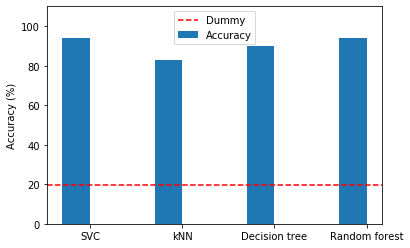

In [13]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

accuracy_list = [94.15, 82.76, 89.80, 93.94] 
  
df_results = pd.DataFrame(accuracy_list, columns =['Accuracy']) 

labels = ['SVC', 'kNN', 'Decision tree', 'Random forest']

x = np.arange(len(labels))  
width = 0.30

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_results['Accuracy'], width, label='Accuracy')

ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#plt.rcParams["figure.figsize"] = (15.4,4.8)
#plt.xticks(rotation=30)
plt.axhline(19.85, color="red", linestyle='--', label='Dummy')
ax.legend()
ax.set_ylim(0, 110)
plt.savefig('../classifiers.png')